# Example 1 of Phoeniks
> **P**ULS **h**ands-on **o**ptimized **e**xtraction *of* $\boldsymbol{n} - \boldsymbol{i}\cdot \boldsymbol{k}$'s


Load a single reference trace and sample trace and extract the refractive index and absorption.

In [1]:
# General Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
%matplotlib notebook

home_dir = os.getcwd()
os.chdir(r"../..")
# Own library
import phoeniks as pk
os.chdir(home_dir)

In [2]:
help(pk)

Help on package phoeniks:

NAME
    phoeniks

PACKAGE CONTENTS
    artificial_sample
    extraction
    optimization_problem
    plot
    post_processing
    svmaf
    thz_data

DATA
    __all__ = ['extraction', 'optimization_problem', 'plot', 'svmaf', 'thz...

FILE
    c:\users\tim\pycharmprojects\phoeniks\phoeniks\__init__.py




# Load data
Loading reference file.

In [3]:
ref_file = "Artifical_Reference.txt"
ref = np.loadtxt(ref_file)
ref, ref.shape

(array([[ 0.00000000e+00, -1.60383681e-05],
        [ 2.44081035e-14,  6.40999140e-07],
        [ 4.88162070e-14,  7.40891296e-06],
        ...,
        [ 9.99023676e-11,  6.33831967e-06],
        [ 9.99267757e-11, -2.84087715e-05],
        [ 9.99511838e-11,  1.45666341e-05]]),
 (4096, 2))

The first column contains the signal in [s], the second column the signal in [V].
We can use the first column to derive the time-axis for the signal and save it seperately:

In [4]:
time = ref[:, 0]

Load the sample file. For this artificial sample, a thickness of 1 mm was used.

In [5]:
sample_thickness = 1e-3
sam_file = "Artifical_Sample_1mm.txt"
sam = np.loadtxt(sam_file)
sam, sam.shape

(array([[0.00000000e+00, 4.84987803e-06],
        [2.44081035e-14, 5.14138791e-07],
        [4.88162070e-14, 1.76140758e-05],
        ...,
        [9.99023676e-11, 1.25153898e-06],
        [9.99267757e-11, 1.13731580e-05],
        [9.99511838e-11, 2.80678054e-06]]),
 (4096, 2))

# Create data object
Feed this data into the THz data object. As a bare minimum, the following data needs to be supplied:
1. time-axis (same for reference and sample trace)
2. Signal of reference measurement in time-domain
3. Signal of sample measurement in time-domain

In [6]:
data = pk.thz_data.Data(time, ref[:, 1], sam[:, 1])

# Plot data
To get a better view on the data, we can create a plot of reference and sample file:

<IPython.core.display.Javascript object>


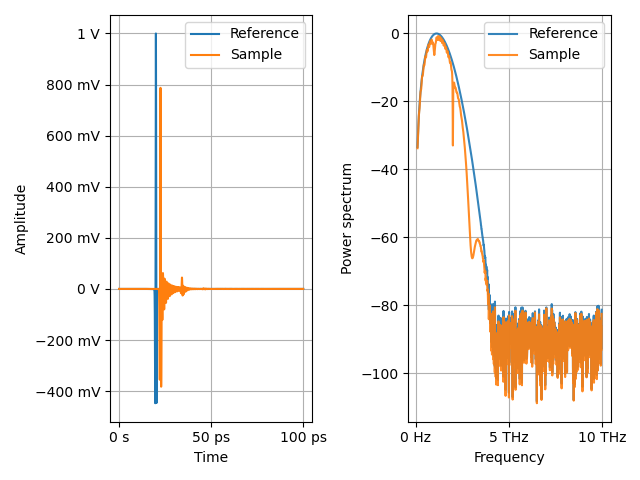

In [7]:
plot = pk.plot.Plot()
plot.plot_data(data)

## Extraction of optimal thickness

In [8]:
extract_obj = pk.extraction.Extraction(data)

In [9]:
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=0.9e12)

<IPython.core.display.Javascript object>


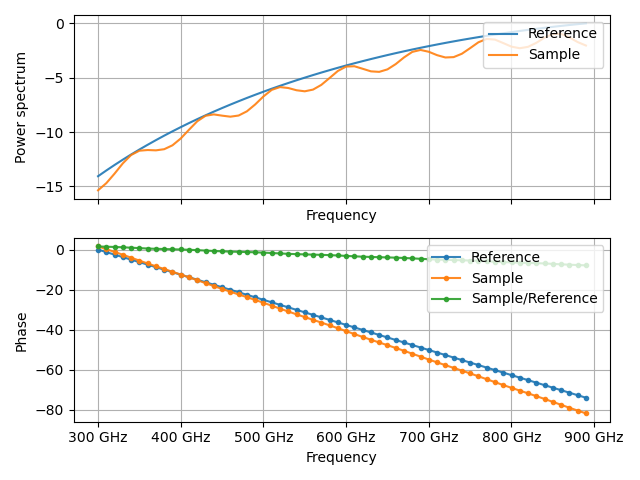

In [10]:
plot.plot_phase(extract_obj)

In [17]:
n, k = extract_obj.get_initial_nk(thickness=990e-6)
delta_max = extract_obj.get_max_delta(thickness=990e-6)

In [18]:
frequency, n_opt, k_opt, alpha_opt = extract_obj.run_optimization(thickness=990e-6)

  0%|          | 0/60 [00:00<?, ?it/s]

In [13]:
from scipy.optimize import curve_fit

In [25]:
def error_function(frequency, n, x):
    n_fit = offset_exponential(x, frequency)
    return np.sqrt(np.sum((n - n_fit) ** 2) / len(n))

def offset_exponential(frequency, a, b, c):
    return a * np.exp(-b * frequency) + c

In [34]:
popt, pcov = curve_fit(offset_exponential, p0=(1,-0.2,1), xdata=frequency / 1e12, ydata=n_opt)
popt

array([ 5.64352810e-05, -5.76785359e+00,  1.75295437e+00])

In [35]:
%timeit curve_fit(offset_exponential, p0=(1,-0.2,1), xdata=frequency / 1e12, ydata=n_opt)

1.98 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
slope = (np.max(n_opt) - np.min(n_opt)) / (np.max(frequency / 1e12) - np.min(frequency / 1e12))
if np.argmax(n_opt) > np.argmin(n_opt):
    curvature = -5
else:
    curvature = 5

In [40]:
slope

0.018007073365086692

In [42]:
%timeit curve_fit(offset_exponential, p0=(slope, curvature, np.min(n_opt)), xdata=frequency / 1e12, ydata=n_opt)

325 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# TODO
x = np.array([0.99, 0.945, 0.874, 0.859, -0.64, 0.573, 0.433])

In [29]:
popt

array([ 5.64352810e-05, -5.76785359e+00,  1.75295437e+00])

<IPython.core.display.Javascript object>


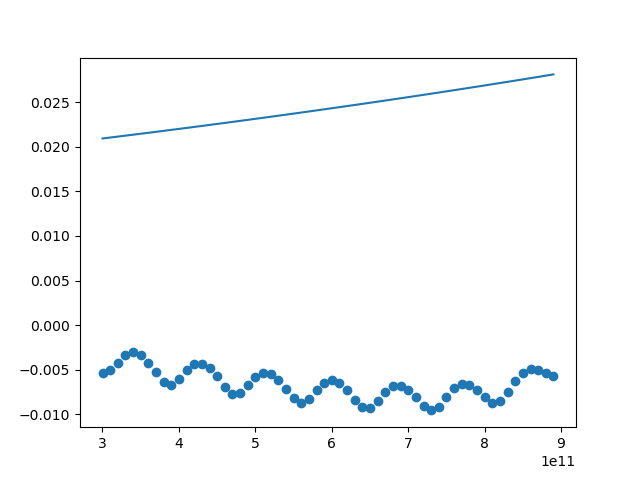

In [56]:
fig, ax = plt.subplots()
ax.scatter(frequency, n_opt - np.min(n_opt) - slope * frequency/1e12, label="f(x)")
ax.plot(frequency, slope*np.exp(0.5*frequency/1e12))

<IPython.core.display.Javascript object>


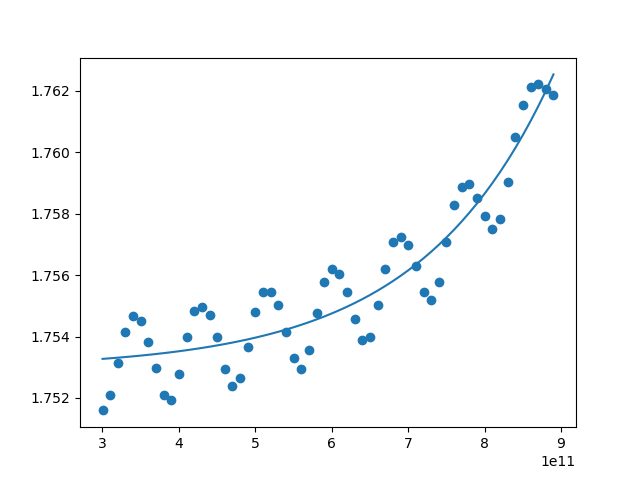

In [28]:
fig, ax = plt.subplots()
ax.scatter(frequency, n_opt)
ax.plot(frequency, offset_exponential(frequency/1e12, *popt))

In [12]:
thickness_array, tv_dict = extract_obj.get_thickness_array(thickness=1e-3,
                                                           thickness_range=50e-6,
                                                           step_size=1e-6)

  0%|          | 0/100 [00:00<?, ?it/s]

tv_1, optimal thickness: 1 mm
tv_2, optimal thickness: 1 mm
tv_n, optimal thickness: 1 mm


<IPython.core.display.Javascript object>


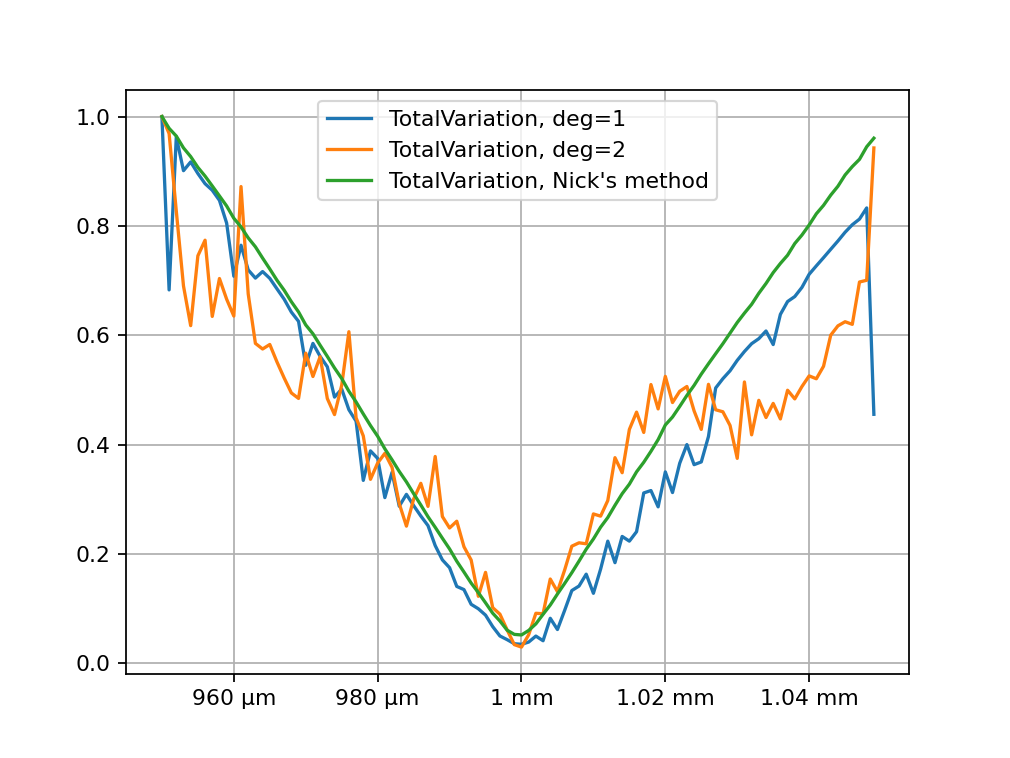

In [13]:
fig, ax = plt.subplots()
ax.plot(thickness_array, tv_dict["tv_1"], label="TotalVariation, deg=1")
ax.plot(thickness_array, tv_dict["tv_2"], label="TotalVariation, deg=2")
ax.plot(thickness_array, tv_dict["tv_n"], label="TotalVariation, Nick's method")
plt.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(EngFormatter("m"))

# Extraction
Start the extraction of the refractive index and absorption.
It is helpfull, to create an extraction object:

In [14]:
data = pk.thz_data.Data(time, ref[:, 1], sam[:, 1])
extract_obj = pk.extraction.Extraction(data)

In [15]:
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=3.7e12)

<IPython.core.display.Javascript object>


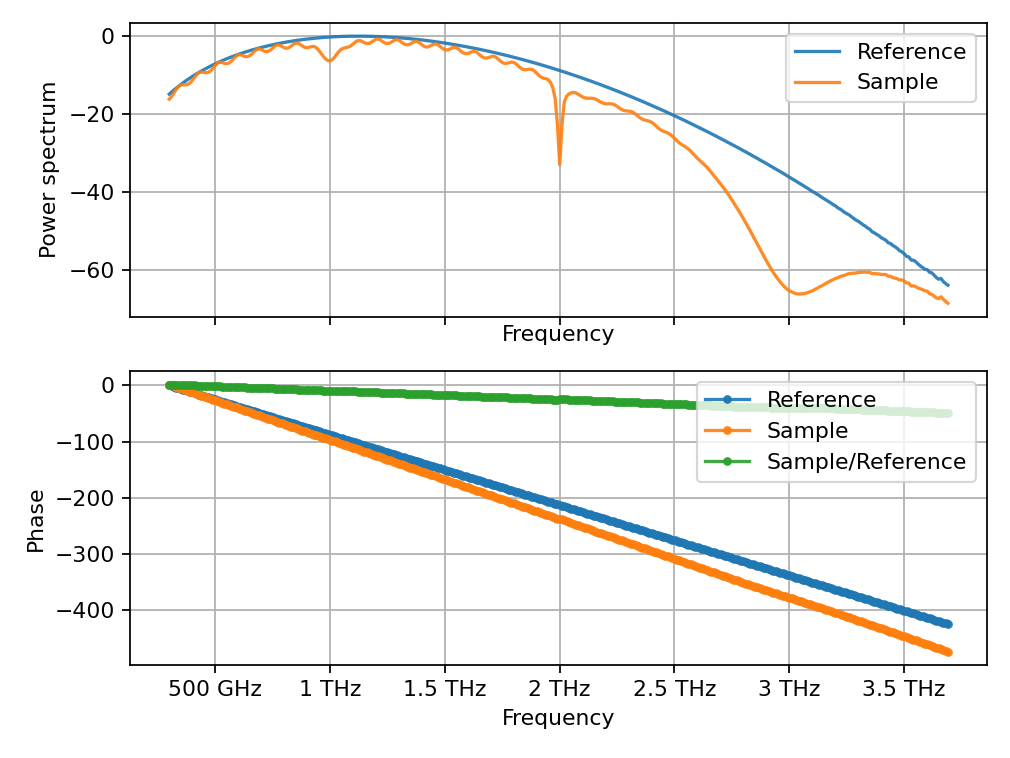

In [16]:
plot.plot_phase(extract_obj)

Getting a first guess of n and k, which is necessary for the optimization algorithm:

<IPython.core.display.Javascript object>


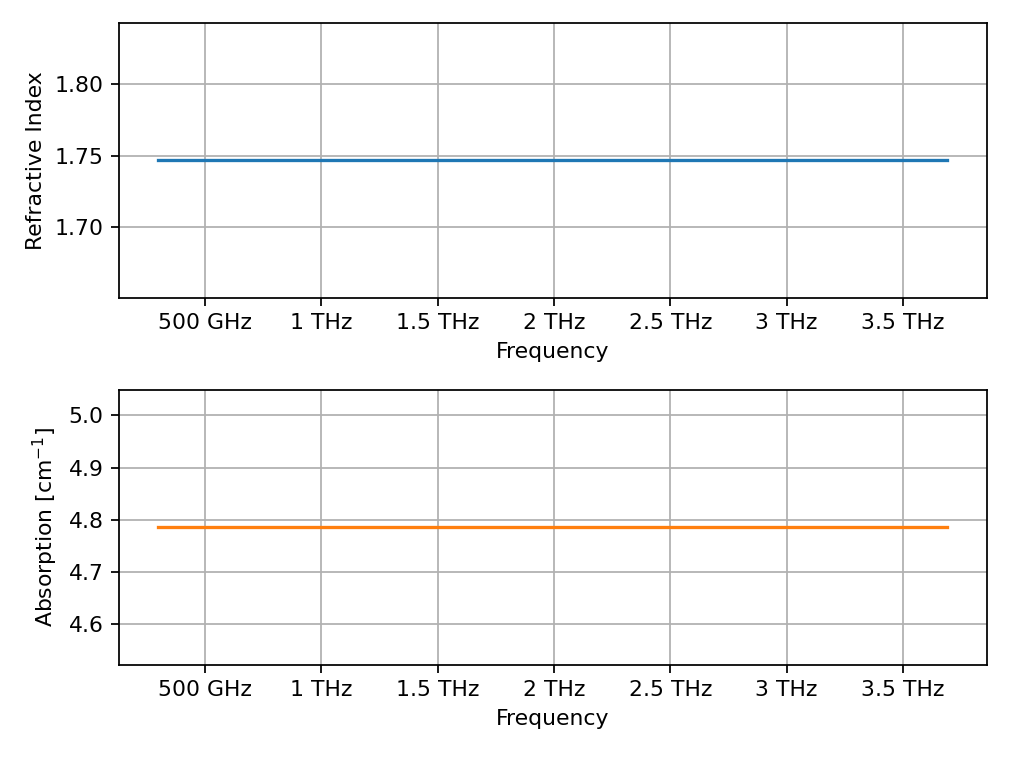

In [17]:
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)
plot.plot_refractive_index(extract_obj.data.frequency, extract_obj.data.n, extract_obj.data.k)

Looking at the time-domain, we cannot only measure the time delta between the peak of reference and sample trace, but also how many echoes (Fabry-Perot reflections) would fit in the remaining time trace:

In [16]:
delta_max = extract_obj.get_max_delta(thickness=sample_thickness)
print(f"Δt:\t\t{EngFormatter('s', places=1)(extract_obj.get_time_shift())}")
print(f"Max. echoes:\t{delta_max}\n")

Δt:		2.5 ps
Max. echoes:	7



# Run optimization

In [19]:
frequency, n_opt, k_opt, alpha_opt = extract_obj.run_optimization(thickness=sample_thickness)

  0%|          | 0/340 [00:00<?, ?it/s]

In [20]:
artificial_data = np.loadtxt("Artifical_n_k_alpha.txt")

<IPython.core.display.Javascript object>


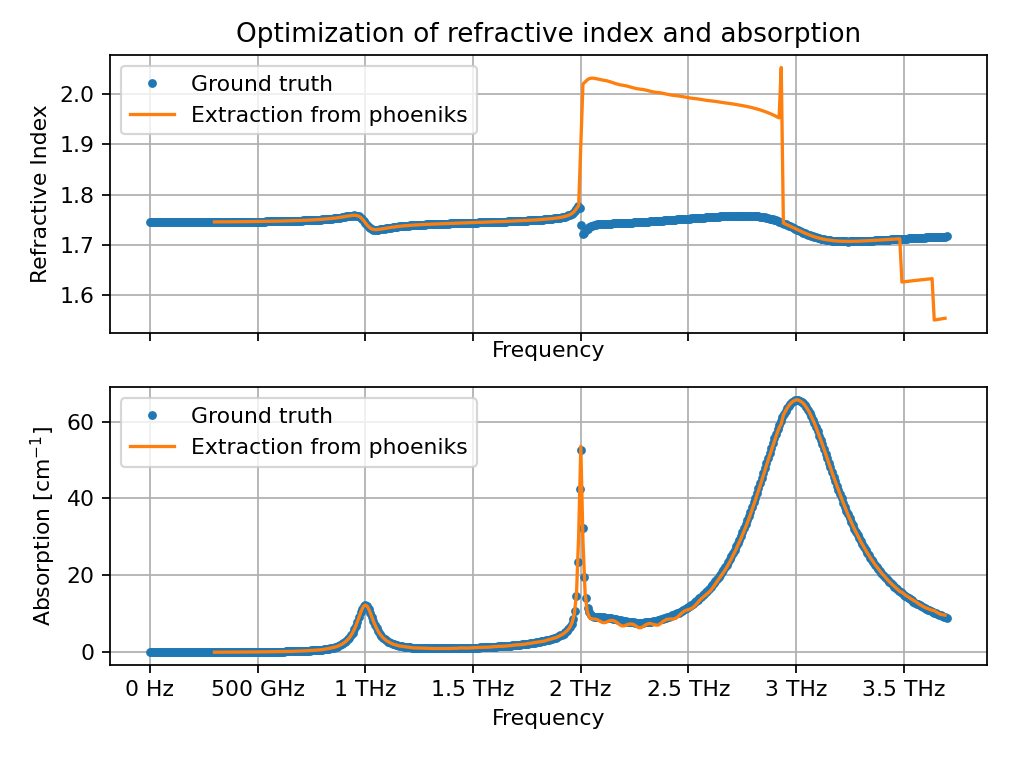

In [21]:
from scipy.constants import c as c_0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_title("Optimization of refractive index and absorption")
ax[0].plot(artificial_data[:, 0], artificial_data[:, 1], ".", label="Ground truth")
ax[0].plot(frequency, n_opt, label="Extraction from phoeniks")
ax[0].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Refractive Index")
ax[0].grid(True)
ax[0].legend()

alpha = 0.01 * 4 * np.pi * k * extract_obj.data.frequency / c_0  # In [cm^-1]
ax[1].plot(artificial_data[:, 0], 0.01 * artificial_data[:, 3], ".", label="Ground truth")
ax[1].plot(frequency, 0.01 * alpha_opt, label="Extraction from phoeniks")
ax[1].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel(r"Absorption [$\mathrm{cm}^{-1}$]")
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()

The algorithm works from one frequency to the next one. If the phase-jump is too large, the algorithm looses track which results in a deviation of the refractive index.
It is often helpful, to "zero-pad" the time-traces, so that the frequency resolution increases. Even though we don't add new data to the measurement files, the smaller frequency steps make it less likely that there is a phase jump between frequency points outside the $\pm\pi$ range.

## Process data with zero-padding

The data is now windowed (to bring the beginning and end of the time-traces to 0) and with zeros padded, to reach a frequency resolution of 2 GHz after applying the FFT.

<IPython.core.display.Javascript object>


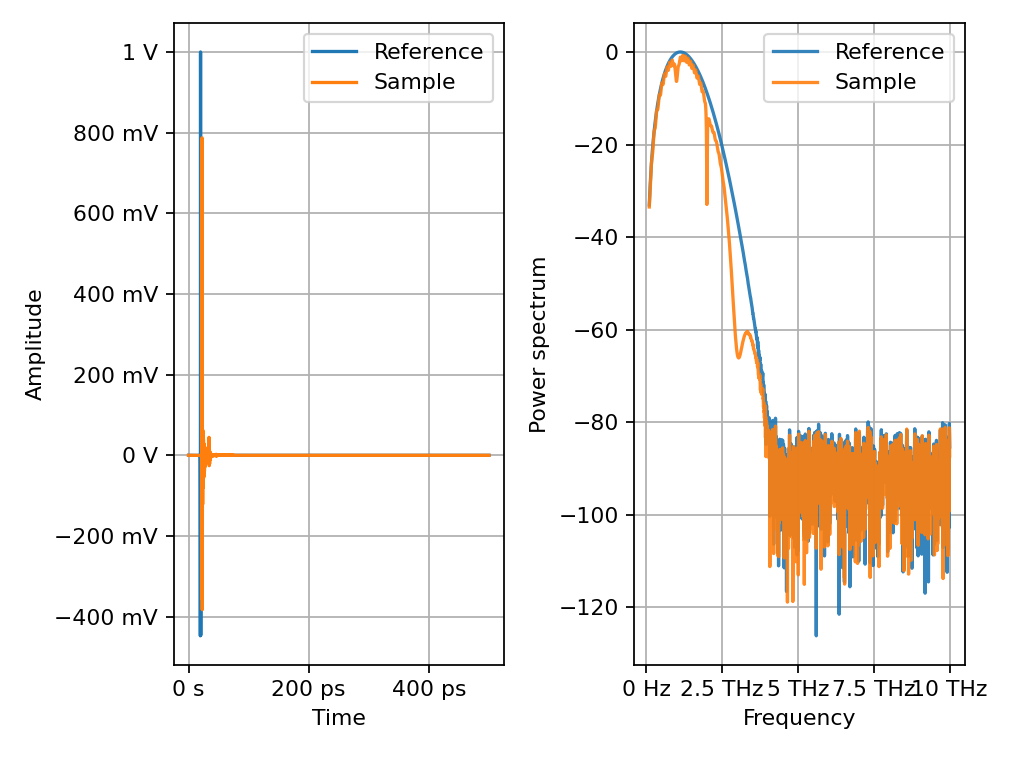

In [22]:
data = pk.thz_data.Data(time, ref[:, 1], sam[:, 1])

data.window_traces(time_start=10e-12, time_end=90e-12)
data.pad_zeros(new_frequency_resolution=2e9)
plot = pk.plot.Plot()
plot.plot_data(data)

In [23]:
extract_obj = pk.extraction.Extraction(data)
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=3.7e12)
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)

In [24]:
frequency, n_opt, k_opt, alpha_opt = extract_obj.run_optimization(thickness=sample_thickness)

  0%|          | 0/1700 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


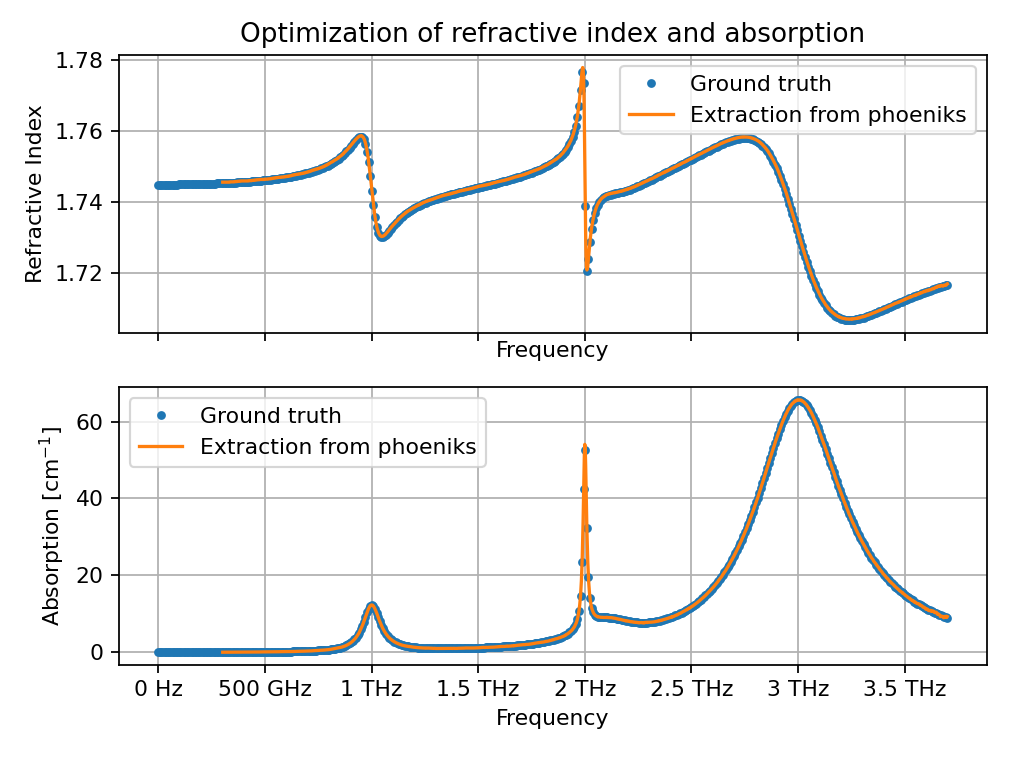

In [25]:
from scipy.constants import c as c_0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_title("Optimization of refractive index and absorption")
ax[0].plot(artificial_data[:, 0], artificial_data[:, 1], ".", label="Ground truth")
ax[0].plot(frequency, n_opt, label="Extraction from phoeniks")
ax[0].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Refractive Index")
ax[0].grid(True)
ax[0].legend()

alpha = 0.01 * 4 * np.pi * k * extract_obj.data.frequency / c_0  # In [cm^-1]
ax[1].plot(artificial_data[:, 0], 0.01 * artificial_data[:, 3], ".", label="Ground truth")
ax[1].plot(frequency, 0.01 * alpha_opt, label="Extraction from phoeniks")
ax[1].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel(r"Absorption [$\mathrm{cm}^{-1}$]")
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()